In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import gymnasium as gym
import numpy as np

In [3]:
# nonlinear, dynamic, cartesian
# from irbfn_mpc.nonlinear_dmpc import NMPCPlanner

# nonlinear, kinematic, frenet
import irbfn_mpc.nonlinear_dmpc_frenet as ndf

In [4]:
from IPython.display import HTML, display
%matplotlib inline

In [5]:
env = gym.make(
    "f1tenth_gym:f1tenth-v0",
    config={
        "map": "Spielberg_blank",
        "observation_config": {
            "type": "features",
            "features": [
                "pose_x",
                "pose_y",
                "delta",
                "linear_vel_x",
                "linear_vel_y",
                "pose_theta",
                "ang_vel_z",
                "beta",
            ],
        },
        "num_agents": 1,
        "control_input": "accl",
    },
    render_mode="rgb_array",
)
env = gym.wrappers.RecordVideo(env, "video_nmpc")

/usr/local/lib/python3.12/dist-packages/f1tenth_gym/envs/action.py:155: UserWarning: Only one control mode specified, using accl for longitudinal control and defaulting to steering speed for steering
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/irbfn/scripts/video_nmpc folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [6]:
track = env.unwrapped.track

In [36]:
import importlib
importlib.reload(ndf)

<module 'irbfn_mpc.nonlinear_dmpc_frenet' from '/home/irbfn/src/irbfn_mpc/nonlinear_dmpc_frenet.py'>

In [37]:
mpc = ndf.NMPCPlanner(track=track, debug=True)

In [38]:
env.unwrapped.add_render_callback(mpc.render_waypoints)
env.unwrapped.add_render_callback(mpc.render_mpc_sol)
env.unwrapped.add_render_callback(mpc.render_local_plan)

In [39]:
poses = np.array(
    [
        [
            env.unwrapped.track.raceline.xs[0] - 0.01,
            env.unwrapped.track.raceline.ys[0] - 0.01,
            env.unwrapped.track.raceline.yaws[0],
        ]
    ]
)
obs, info = env.reset(options={"poses": poses})
done = False

step = 0

all_states = []

while not done and step <= 10000:
    current_state = obs["agent_0"]
    
    if step < 10:
        accl = 3.0
        steer_vel = 0.0
    else:
        accl, steer_vel, debug_states = mpc.plan(current_state)
        # print(f"accl {accl}, steer_vel {steer_vel}")
        all_states.append(debug_states)
        
    action = env.action_space.sample()
    action[0] = [steer_vel, accl]
    # print(f"current state {current_state}")
    # print(f"goal state {goal_state}")
    # print(f"taking action {action[0]}")

    obs, step_reward, done, truncated, info = env.step(action)
    step += 1

env.close()

CasADi - 2024-09-09 20:41:09 MESSAGE("calling "gcc -O3 -fPIC -c jit_tmprMONpZ.c -o ./tmp_casadi_compiler_shellJBQap0.o"") [.../casadi/solvers/shell_compiler.cpp:229]
CasADi - 2024-09-09 20:42:19 MESSAGE("calling "gcc ./tmp_casadi_compiler_shellJBQap0.o -o ./tmp_casadi_compiler_shellJBQap0.so -shared"") [.../casadi/solvers/shell_compiler.cpp:248]
Moviepy - Building video /home/irbfn/scripts/video_nmpc/rl-video-episode-0.mp4.
Moviepy - Writing video /home/irbfn/scripts/video_nmpc/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/irbfn/scripts/video_nmpc/rl-video-episode-0.mp4


In [40]:
env.close()

In [56]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.9g" % x))

In [57]:
print(mpc.opti.debug.value(mpc.X))

[[337.881529 338.680993 339.480541 340.280252 341.08008 341.879946]
 [0.00910430145 0.0156671373 0.0195536813 0.0210327834 0.0208341881 0.0198486097]
 [-0.00218204828 -0.0020291361 -0.000551262862 0.000211998906 0.000323886473 0.000323886473]
 [7.99494553 7.99473346 7.99624108 7.99786614 7.99864531 7.99865172]
 [0.0299469698 0.0366144639 0.0384787687 0.0274676072 0.0126627642 0.00225747594]
 [-0.0370724052 -0.0407393909 -0.0241055668 -0.00264495154 0.00718946105 0.00860278948]
 [0.00604844377 0.0020040051 -0.00154522255 -0.00285097815 -0.00251267681 -0.00169773601]]


In [58]:
print(mpc.opti.debug.value(mpc.U))

[[-0.000515979468 0.0165739332 0.0167157416 0.00771187116 -4.7054202e-09]
 [0.00152912182 0.0147787324 0.00763261768 0.00111887567 -1.08505524e-13]]


In [59]:
print(mpc.opti.debug.value(mpc.P))

[[337.881529 0 0 0 0 0]
 [0.00910430145 0 0 0 0 0]
 [-0.00218204828 0 0 0 0 0]
 [7.99494553 8 8 8 8 8]
 [0.0299469698 0 0 0 0 0]
 [-0.0370724052 0 0 0 0 0]
 [0.00604844377 0 0 0 0 0]
 [0 4.16000003e-05 4.16000003e-05 4.16000003e-05 4.16000003e-05 4.16000003e-05]]


In [60]:
import casadi as ca

In [61]:
gs = ca.vertcat(0.0, 0.0, 0.0, mpc.ref_path[3][-1], 0.0, 0.0, 0.0, mpc.ref_path[5][0])
accl, steerv = mpc.mpc_prob_solve(goal_state=gs, current_state=obs["agent_0"])

In [62]:
obs["agent_0"]

{'pose_x': 0.19378377,
 'pose_y': -0.7948495,
 'delta': -0.0021820483,
 'linear_vel_x': 7.9949455,
 'linear_vel_y': 0.02994697,
 'pose_theta': 3.409448,
 'ang_vel_z': -0.037072405,
 'beta': 0.0037457203}

In [63]:
env.close()

In [64]:
import glob
import io
import base64

for video_file in glob.glob("video_nmpc/*.mp4"):
    video = io.open(video_file, "rb").read()
    encoded = base64.b64encode(video).decode("ascii")
    display(
        HTML(
            f"""<video width="800" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>"""
        )
    )

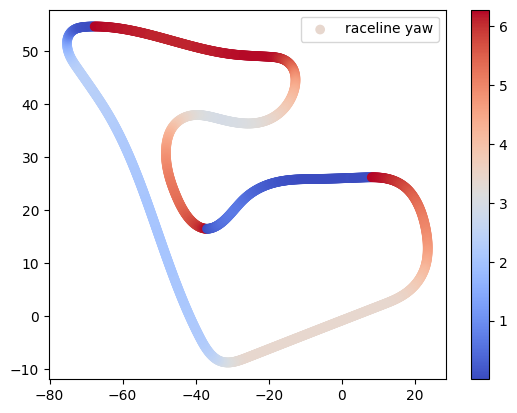

In [65]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(track.raceline.xs, track.raceline.ys, c=track.raceline.yaws, cmap="coolwarm", label="raceline yaw")
plt.legend()
plt.colorbar()
plt.show()

In [66]:
len(all_states)

9964

In [67]:
all_states_np = np.array(all_states)
all_states_np.shape

(9964, 8)

In [68]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.10g" % x))

In [69]:
all_states_rounded = np.round(all_states_np, 1)
keys = ["s", "ey", "delta", "vx", "vy",  "wz", "epsi", "curv"]
for i in range(all_states_rounded.shape[1]):
    entries, counts = np.unique(all_states_rounded[:, i], return_counts=True)
    print(f" {keys[i]}: {entries}")
    print(f"counts:      {counts}")

 s: [0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 ... 335.2 335.3 335.4 335.5 335.6 335.7 335.8 335.9 336 336.1 336.2 336.3 336.4 336.5 336.6 336.7 336.8 336.9 337 337.1 337.2 337.3 337.4 337.5 337.6 337.7 337.8 337.9 338 338.1]
counts:      [ 6 10  7  6  4  5  5  3  4  4  4  3  3  3  4  3  3  3  3  3  3  2  4  2  3  2  4  2  3  2 ...  3  3  2  2  3  3  2  2  3  3  2  2  3  3  2  2  3  3  2  2  3  3  2  2  3  3  2  1  1  1]
 ey: [-0.3 -0.2 -0.1 0 0.1 0.2 0.3]
counts:      [ 116  870  548 4688  919 2113  710]
 delta: [-0.1 -0 0.1]
counts:      [ 997 8561  406]
 vx: [0.3 0.4 0.5 0.6 0.7 0.8 0.9 1 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3 3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5 5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7 7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8]
counts:      [   1    1    1    1    1    1    1    1    1    

In [70]:
np.arange(-1., 1 + 0.2, 0.2)

array([-1, -0.8, -0.6, -0.4, -0.2, -2.220446049e-16, 0.2, 0.4, 0.6, 0.8, 1])